C:\Users\A518804\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\A518804\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


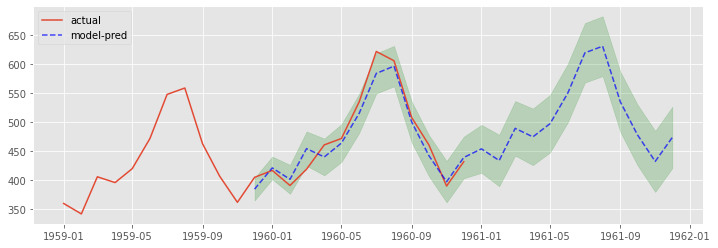

In [1]:
#参考　https://www.kumilog.net/entry/sarima-pv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import statsmodels.api as sm # version 0.8.0以上

# CSVファイル読み込み（事前にダウンロードしたCSVファイルを利用）
df = pd.read_csv('./AirPassengers.csv')

# Pandas.Seriesにデータを格納
passengers = pd.Series(df['#Passengers'], dtype='float') #　乗客数
passengers.index = pd.to_datetime(df['Month']) # 日付インデックス

# 元データ分割：passengers 1949-01 ～ 1960-12
passengers_train2 = passengers['1949-01':'1959-12'] # 訓練データ（モデル作成用）
passengers_test2 = passengers['1960-01':'1960-12'] # テストデータ1年分（検証用）

# SRIMAモデル
sarimax_train = sm.tsa.SARIMAX(passengers_train2, 
                        order=(3, 1, 3), 
                        seasonal_order=(0, 1, 1, 12),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()

#　モデルによる予測
predict2_dy = sarimax_train.get_prediction(start ='1959-12', end='1961-12') # 2年分の未来予測
predict2_dy_ci = predict2_dy.conf_int() # 信頼区間取得

#　グラフ表示
plt.figure(figsize=(12, 4))
plt.plot(passengers['1959-01':], label="actual") # 実データプロット
plt.plot(predict2_dy.predicted_mean, c="b", linestyle='--', label="model-pred", alpha=0.7) # 予測プロット

# 予測の95%信頼区間プロット（帯状）
plt.fill_between(predict2_dy_ci.index, predict2_dy_ci.iloc[:, 0], predict2_dy_ci.iloc[:, 1], color='g', alpha=0.2)

plt.legend(loc='upper left')

In [2]:
sarimax_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          #Passengers   No. Observations:                  132
Model:             SARIMAX(3, 1, 3)x(0, 1, [1], 12)   Log Likelihood                -384.674
Date:                              Tue, 07 Dec 2021   AIC                            785.347
Time:                                      17:17:27   BIC                            806.425
Sample:                                  01-01-1949   HQIC                           793.885
                                       - 12-01-1959                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2221      0.122      1.813      0.070      -0.018       0.462
ar.L2         -0.3786      0.101     -3.757      0.000      -0.576      -0.181
ar.L3          0.6478      0.106      6.138      0.000       0.441       0.855
ma.L1         -0.4241    105.534     -0.004      0.997    -207.267     206.418
ma.L2          0.4562    276.769      0.002      0.999    -542.002     542.914
ma.L3         -0.9793    372.278     -0.003      0.998    -730.631     728.672
ma.S.L12      -0.1454      0.113     -1.287      0.198      -0.367       0.076
sigma2        98.1813   3.73e+04      0.003      0.998    -7.3e+04    7.32e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 2.44
Prob(Q):                              0.74   Prob(JB):                         0.29
Heteroskedasticity (H):               1.47   Skew:                            -0.09
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\A518804\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


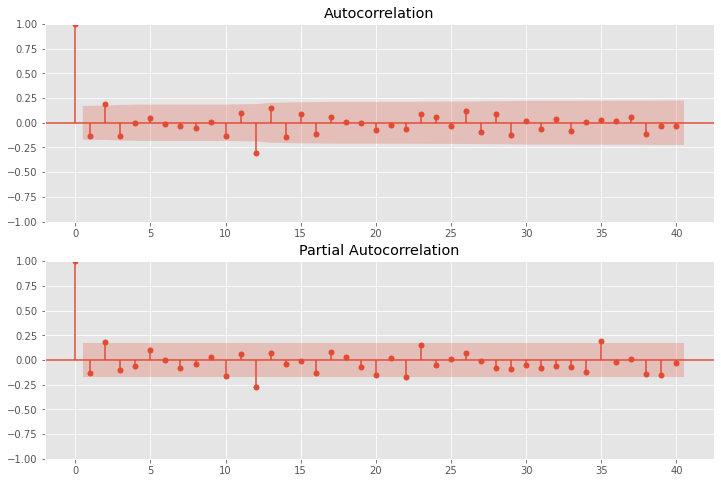

In [3]:
residSARIMA = sarimax_train.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=40, ax=ax2)

In [4]:
# 総当たりで、AICが最小となるSARIMAの次数を探す
max_p = 3
max_q = 3
max_d = 1
max_sp = 1
max_sq = 1
max_sd = 1

pattern = max_p*(max_q + 1)*(max_d + 1)*(max_sp + 1)*(max_sq + 1)*(max_sd + 1)

modelSelection = pd.DataFrame(index=range(pattern), columns=["model", "aic"])
pattern

192

In [12]:
#Error メッセージ非表示
import warnings
warnings.simplefilter('ignore')

# 自動SARIMA選択
num = 0

for p in range(1, max_p + 1):
    for d in range(0, max_d + 1):
        for q in range(0, max_q + 1):
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1):
                    for sq in range(0, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(
                            passengers_train2, order=(p,d,q), 
                            seasonal_order=(sp,sd,sq,12), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False
                        ).fit()
                        modelSelection.iloc[num]["model"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), season=("+ str(sp) + ","+ str(sd) + "," + str(sq) + ")"
                        modelSelection.iloc[num]["aic"] = sarima.aic
                        num = num + 1

                        # AIC最小モデル
modelSelection[modelSelection.aic == min(modelSelection.aic)]

,model,aic
187,"order=(3,1,3), season=(0,1,1)",785.347


### メモ　外生変数を使い場合

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib as plt
plt.rcParams['font.family'] = 'IPAexGothic'

df = pd.read_csv(r'C:\Users\***\OneDrive\ドキュメント\Study\Qiita\SampleData.csv',
                 engine='python',
                 index_col=[0],
                 parse_dates=[0],
                )
df.index.freq = 'H'

# 予測日を2017年8月3日として、過去3日間のデータをSARIMAXのendogとしました。
# endog,exogは共に３日分のデータです。（exogが外生変数(外気温))
# order,seasonal_orderはコレログラムとか使って推定するのですが、面倒だったのでaicが一番低いものを入れました。

forecastdate = pd.datetime(2017,8,3,0,0)
train_df = df.loc[forecastdate -pd.offsets.Day(3) :forecastdate - pd.offsets.Hour(1),:]
temp_df = pd.DataFrame(df.loc[forecastdate:forecastdate + pd.offsets.Hour(23),'外気温度'])
ele_df = df.loc[forecastdate:forecastdate + pd.offsets.Hour(23),'高圧受電']

fit_with_temp = sm.tsa.statespace.SARIMAX(  endog=train_df.loc[:,'高圧受電'],
                                            exog=train_df.loc[:,'外気温度'],
                                            enforce_invertibility=False,
                                            enforce_stationarity=False,
                                            order=(1,0,1),
                                            seasonal_order=(1,0,0,24)).fit()

fit = sm.tsa.statespace.SARIMAX(endog=train_df.loc[:,'高圧受電'],
                                enforce_invertibility=False,
                                enforce_stationarity=False,
                                order=(1,0,1),
                                seasonal_order=(1,0,0,24)).fit()

result_df = pd.DataFrame({'実績値':ele_df,
                          '予測値_外生変数有':fit_with_temp.forecast(steps=24,exog=temp_df),
                          '予測値_外生変数無':fit.forecast(steps=24)
                         }
                        )

result_df.plot(figsize=(15,5))


OSError: [Errno 22] Invalid argument: 'C:\\Users\\***\\OneDrive\\ドキュメント\\Study\\Qiita\\SampleData.csv'